# Advanced Statistical Inference
## Gaussian Process Regression


## 1. Aims
- To sample from a Gaussian process prior distribution.
- To implement Gaussian process inference for regression.
- To use the above to observe samples from a Gaussian process posterior distribution.
- To evaluate how different hyperparameter settings impact model quality.

## 2. Introduction

Gaussian processes (henceforth GPs) achieve greater flexibility over parametric models by imposing
a preference bias as opposed to restrictive constraints. Although the parameterisation of GPs
allows one to access a certain (infinite) set of functions, preference can be expressed using a prior
over functions. This allows greater freedom in representing data dependencies, thus enabling the
construction of better-suited models. In this lab, we shall cover the basic concepts of GP regression.
For the sake of clarity, we shall focus on univariate data, which enables better visualisation of the
GP. Nonetheless, the code implemented within this lab can very easily be extended to handle
multi-dimensional inputs.

## 3. Sampling from GP Prior

We shall consider a one-dimensional regression problem, whereby the inputs x are transformed by
a function $f(x) = sin(exp(0.03 * x))$. 

Generate 200 random points, $x$, in the range $[-20, 80]$, and compute their corresponding function
values, $t$. The target function can then be plotted accordingly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as ss
from sklearn import metrics
from scipy.spatial.distance import cdist

In [2]:
start = -20
stop = 80
step = abs(start - stop)/200

In [3]:
x = np.random.uniform(start,stop,200)

In [4]:
f_x = np.sin(np.exp(0.03*x))

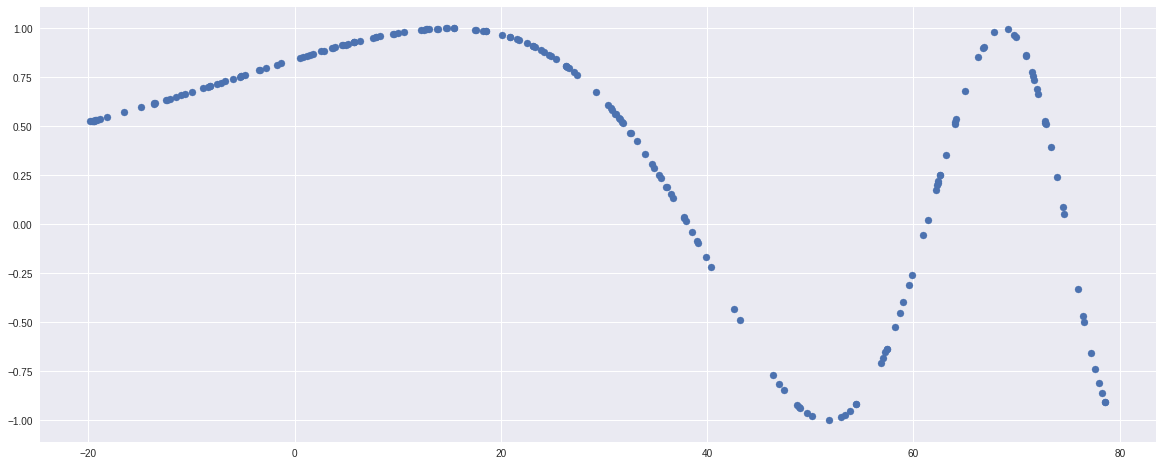

In [5]:
plt.figure(figsize=(20,8))
plt.scatter(x, f_x)
plt.show()

Recall that since GPs are non-parametric, we define a prior distribution over functions (models),
specified as a multivariate Gaussian distribution $p(f) = N (\mu, \Sigma)$.

Without loss of generality, we shall assume a zero-mean GP prior, i.e. $\mu = 0$. The covariance
matrix of the distribution, $\Sigma$, may then be computed by evaluating the covariance between the
input points. For this tutorial, we shall consider the widely used squared-exponential (RBF)
covariance (also referred to as the kernel function), which is defined between two points as: 

$k(x, x') = \sigma_f^2 \exp \Big( -\dfrac {(x-x')^2}{2l^2} \Big) $.

This kernel is parameterised by a lengthscale parameter $l$, and variance $\sigma_f^2$ . Given that the true
function may be assumed to be corrupted with noise, we can also add a noise parameter, $\sigma_n^2$ , to
the diagonal entries of the resulting kernel matrix, $K$, such that

$K = K + \sigma_n^2I$.



Complete the `compute_kernel()` function for computing RBF covariance between two sets of input points. Hint: The ‘cdist’ function in scipy can be used for evaluating the pairwise Euclidean distance between two sets of points.

In [6]:
def compute_kernel(x1, x2, ls, var_f):
    # params:
    # ls: lengthscale
    # var_f: variance of f
    x1, x2 = np.asarray(x1), np.asarray(x2)
    return np.multiply(np.exp(np.multiply(-cdist(x1.reshape(-1,1), x2.reshape(-1,1))**2, 1/(2*(ls)**2))), var_f)

In [7]:
lenscale = 10
var_f = 0.2

Assuming a zero-mean prior, and using the kernel matrix constructed with compute kernel for input points x, we can sample from the prior distribution using the numpy `multivariate_normal()` function.

In [9]:
mu = np.zeros(len(x))
K = compute_kernel(x, x, lenscale, var_f)
R = np.random.multivariate_normal(mu,K,4)

On the same figure where we plotted the true function, draw four samples from the prior distri-
bution and plot them accordingly. In order to better understand the role of the hyperparameters,
observe how altering them impacts the shape of the prior samples.

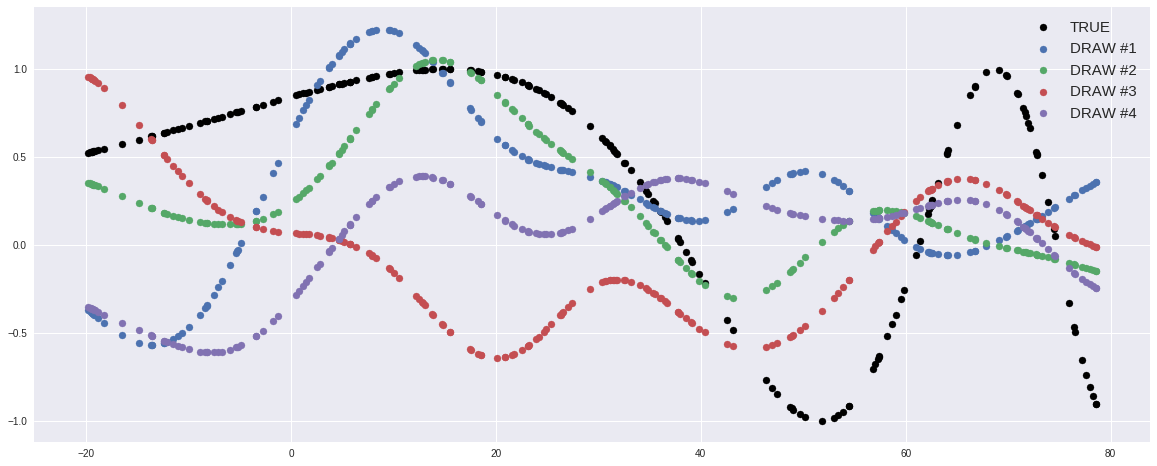

In [10]:
plt.figure(figsize=(20,8))
plt.scatter(x, f_x, c='k', label='TRUE')
ax = plt.gca()
for i in range(4):
    plt.scatter(x, R[i], label='DRAW #'+str(i+1))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size':15})
plt.show()

## 4. GP Inference

Recall that the prior represents our prior beliefs before observing the function values of any data points. Suppose we can now observe 3 points at random from the input data; we would expect that with this additional knowledge, the functions drawn from the updated GP distribution would be constrained to pass through these points (or at least close if corrupted with noise). The combination of the prior and the data leads to the posterior distribution over functions.

Assign 3 points at random from $x$ (and their corresponding function values) to `obs_x` and `obs_t`
respectively. You are encouraged to use the following initial configuration:

In [11]:
lenscale = 10
var_f = 2
var_n = 1e-6

In [29]:
numObs = 10
obs_x = np.random.choice(x, numObs, replace=False)
obs_t = np.sin(np.exp(0.03*obs_x))

Complete the provided implementation of `gp_inference` for evaluating the posterior GP mean and variance using the equations given in the lecture.

<b>Note</b>: As we have encountered in previous labs, matrix inversions can be both numerically troublesome and slow to compute. In this lab, we shall avoid computing direct matrix inversions by instead considering Cholesky decompositions for solving linear systems. The steps for using Cholesky within GP inference are outlined as comments within the provided code. Even so, you are encouraged to read more about Cholesky decompositions for GPs by consulting Appendix A.4 of Gaussian Processes for Machine Learning (Rasmussen and Williams, 2005) - available online!

In [30]:
def gp_inference(obs_x, obs_t, x_new, lenscale=10, var_f=2, var_n=1e-6):
    K_obs = compute_kernel(obs_x, obs_x, lenscale, var_f) + var_n*np.identity(len(obs_x))
    L = np.linalg.cholesky(K_obs) # returns L of the Cholesky decomposition, a lower triangular matrix
    tmp = scipy.linalg.solve_triangular(L, obs_t, lower=True) # returns x s.t.: L*x=obs_t, where L is a lower triangular matrix (lower=True)
    alpha = scipy.linalg.solve_triangular((L.T), tmp, lower=False)
    K_obs_pred = compute_kernel(obs_x, x_new, lenscale, var_f) 
    K_pred = compute_kernel(x_new, x_new, lenscale, var_f)   
    post_m = np.dot(K_obs_pred.T, alpha)
    v = scipy.linalg.solve_triangular(L, K_obs_pred, lower=True)
    post_v = K_pred - np.dot(v.T, v)
    nll = np.multiply(np.multiply(obs_t.T, alpha), -0.5) - np.log(np.trace(L)) - np.log(2*np.pi)*len(obs_x)/2
    return post_m, post_v, nll

In [31]:
x_new = np.arange(start, stop, step)

## 5. Sampling from GP Posterior

Now that you have computed the posterior mean and variance, create a new figure once again
showing the true function. To this figure, add the posterior mean and 95% confidence interval;
this can be achieved using the following code:

In [34]:
numSamples = 10
# post_m, post_v = gp_inference(obs_x, obs_t, x_new, lenscale, var_f, var_n)
post_m, post_v, nll = gp_inference(obs_x, obs_t, x_new, lenscale, var_f, var_n)
R2 = np.random.multivariate_normal(post_m,post_v,numSamples)
post_stdv = np.sqrt(np.diagonal(post_v))

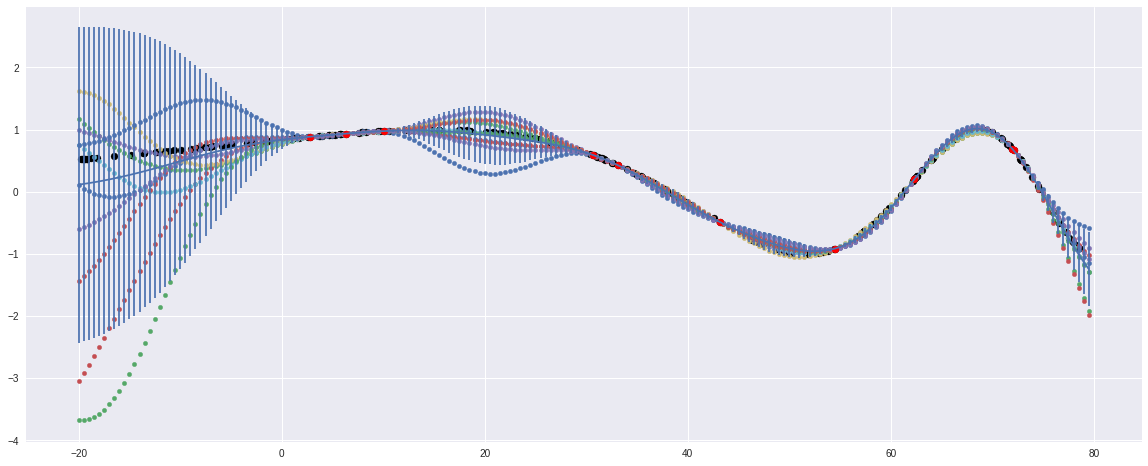

In [33]:
plt.figure(figsize=(20,8))
plt.scatter(x, f_x, c='k')
for i in range(numSamples):
    plt.scatter(x_new, R2[i], s=20)
plt.scatter(obs_x, obs_t, c='r')
plt.errorbar(x_new, post_m, yerr=ss.t.ppf(0.95, numObs-1)*post_stdv) # ppf(percentage, degree_of_freedom)

plt.show()


Note that we should also add the noise variance to the predictive variance of the posterior. Fix
this accordingly.

Additionally, as we did with the prior distribution, sample four functions from the posterior and
plot them on the same figure. Comment on what you observe. You should also view how the
posterior mean and variance improve when more observations are included in the GP inference
procedure.

As a measure of model quality, you should also compute the log marginal likelihood of the model.
To this end, complete the code provided in gp inference to include the nll term. Hint: Refer to
Algorithm 2.1 in Chapter 2 of the book referenced above for details on how to compute this term
efficiently.

## Bonus: Parameter Optimisation


Optimise the hyperparameters of the model by minimising the negative log-likelihood of the model.
For a complete solution, you should include the derivatives of the objective function with respect
to the parameters being optimised.

**Note** that the parameters $l$, $\sigma_f^2$ , and $\sigma_n^2$ are supposed to be positive. It is possible that the
optimisation algorithm attempts to evaluate the log-likelihood in regions of the parameter space where one or more of these parameters are negative, leading to numerical issues. An easy way around this is to optimise a transformed version of covariance parameters using the logarithm transformation. In particular, define $\psi_l = log(l)$, $\psi_f = log(\sigma_f^2 )$, and $\psi_n = log(\sigma_n^2 )$, and optimise with respect to the $\psi$ parameters. The optimisation problem in the transformed space is now unbounded, and the gradient of the log-likelihood should be computed with respect to the $\psi$ parameters.

## Work In Progress...
